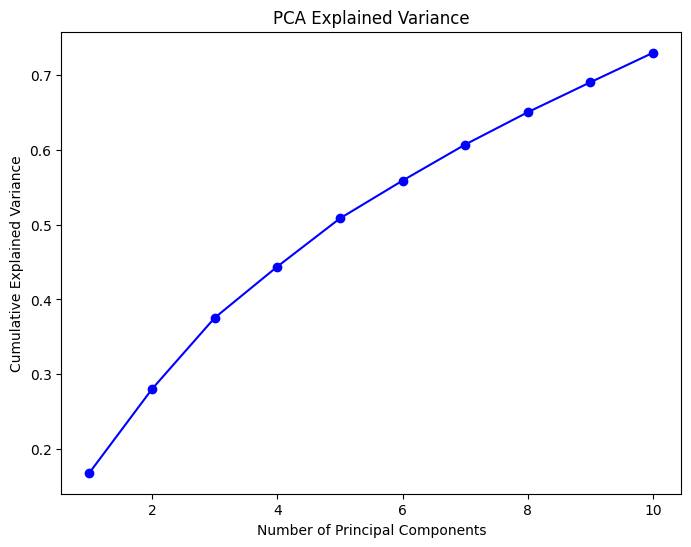

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


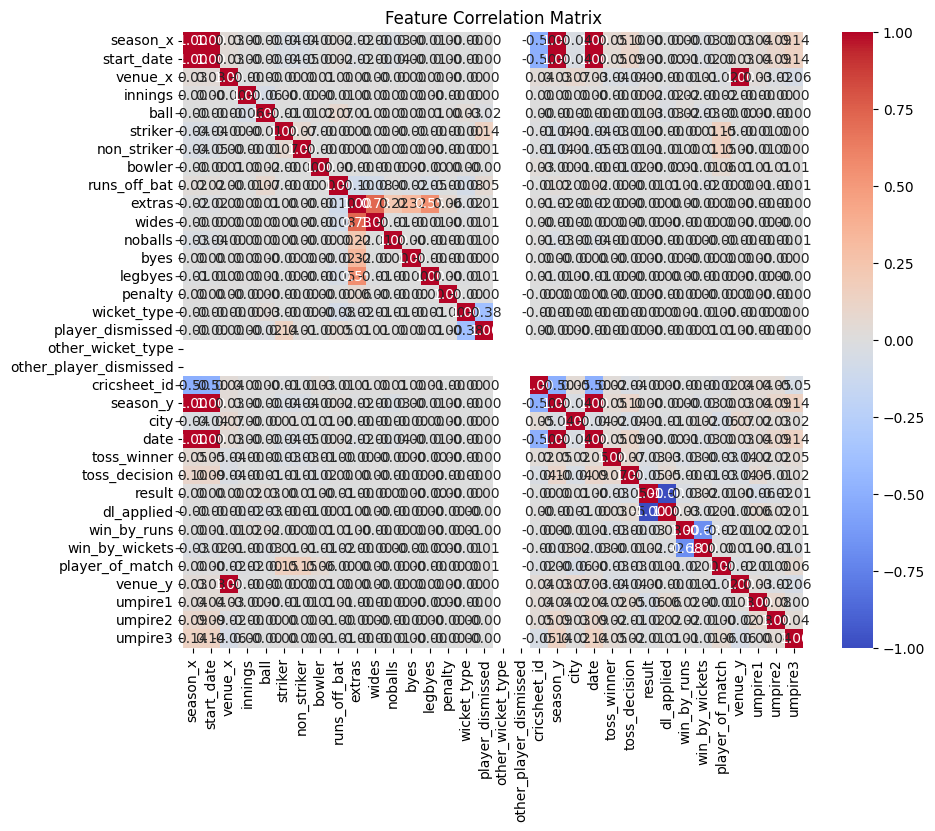

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, r2_score

# Load datasets
match_data_path = "/kaggle/input/odi-mini-project/ODI_Match_Data.csv"
match_info_path = "/kaggle/input/odi-mini-project/ODI_Match_info.csv"

df_match_data = pd.read_csv(match_data_path, dtype=str)
df_match_info = pd.read_csv(match_info_path, dtype=str)

# Merge datasets on match_id
if 'match_id' in df_match_data.columns and 'id' in df_match_info.columns:
    df_merged = df_match_data.merge(df_match_info, left_on='match_id', right_on='id', how='left')
    df_merged.drop(columns=['id'], inplace=True, errors='ignore')
else:
    raise KeyError("Ensure 'match_id' exists in match data and 'id' exists in match info")

# Handling missing values
def fill_missing_values(df):
    fill_values = {
        'wides': 0, 'noballs': 0, 'byes': 0, 'legbyes': 0, 'penalty': 0,
        'wicket_type': 'Not Out', 'player_dismissed': 'None',
        'other_wicket_type': 'None', 'other_player_dismissed': 'None',
        'player_of_match': 'Unknown'
    }
    df.fillna(fill_values, inplace=True)
    return df

df_merged = fill_missing_values(df_merged)

# Convert season column to numeric format
if 'season' in df_merged.columns:
    df_merged['season'] = df_merged['season'].astype(str).str.extract(r'(\d{4})')[0]
    df_merged['season'] = pd.to_numeric(df_merged['season'], errors='coerce')
    df_merged['season'].fillna(df_merged['season'].median(), inplace=True)
    df_merged['season'] = df_merged['season'].astype(int)

# Define feature and target columns
if 'winner' in df_merged.columns and 'team1' in df_merged.columns:
    df_merged['match_result'] = (df_merged['winner'] != df_merged['team1']).astype(int)
else:
    raise KeyError("Columns 'winner' or 'team1' not found in the dataset")

# Drop potential leakage columns
drop_cols = ['match_id', 'winner', 'team1', 'team2', 'batting_team', 'bowling_team']
df_merged.drop(columns=[col for col in drop_cols if col in df_merged.columns], inplace=True)

y = df_merged['match_result']
X = df_merged.drop(columns=['match_result'])

# Encode categorical columns dynamically
label_encoders = {}
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Replace infinite values
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any remaining NaN values
X.dropna(inplace=True)
y = y.loc[X.index]

# Sample a subset of data for faster training
X_sample, y_sample = X.sample(n=50000, random_state=42), y.sample(n=50000, random_state=42)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

# Normalizing numerical features
numerical_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = MinMaxScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Drop NaN values before applying PCA
X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]
X_test.dropna(inplace=True)
y_test = y_test.loc[X_test.index]
# Handle Class Imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Applying PCA on training data only
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train[numerical_columns])
X_test_pca = pca.transform(X_test[numerical_columns])

X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
X_train_pca.reset_index(drop=True, inplace=True) #add this line
X_test_pca.reset_index(drop=True, inplace=True) #add this line
y_train.reset_index(drop=True, inplace=True) #add this line
y_test.reset_index(drop=True, inplace=True) #add this line
# PCA Line Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

# Correlation Matrix Plot
plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

Accuracy: 0.9757
Precision: 0.9717022202873313
Recall: 0.9753113393052217
Confusion Matrix:
 [[5293  130]
 [ 113 4464]]


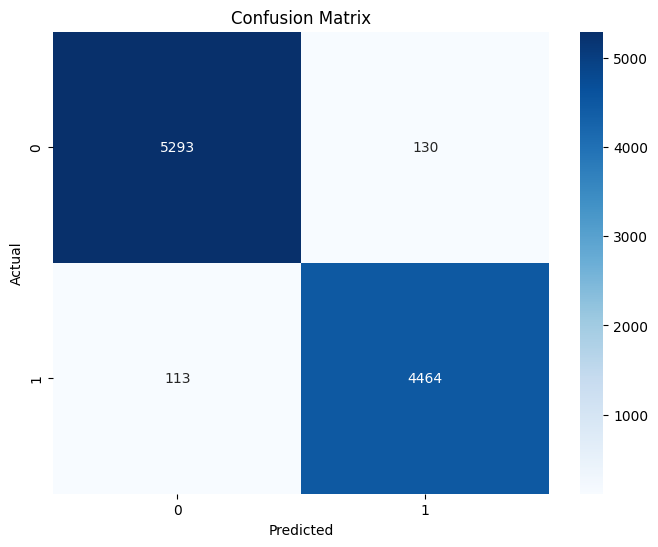

Cross-Validation Scores: [0.97245274 0.96542185 0.96957123 0.96934071 0.96934071]
Mean Cross-Validation Score: 0.9692254495159058


In [108]:
# Cell 2: Random Forest Model and Evaluation (Corrected for Overfitting)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Train Random Forest Model (Reduced Complexity)
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42) #added max_depth and min_samples_split
model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:\n", conf_matrix)

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Cross-Validation
cross_val_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5) #5-fold cross validation
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {cross_val_scores.mean()}")

XGBoost Test Accuracy: 0.98
XGBoost Test Precision: 0.98
XGBoost Test Recall: 0.98


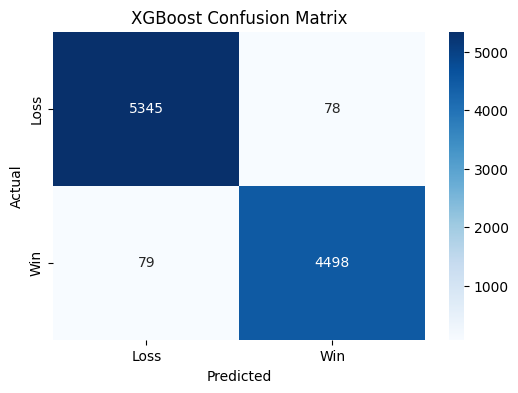

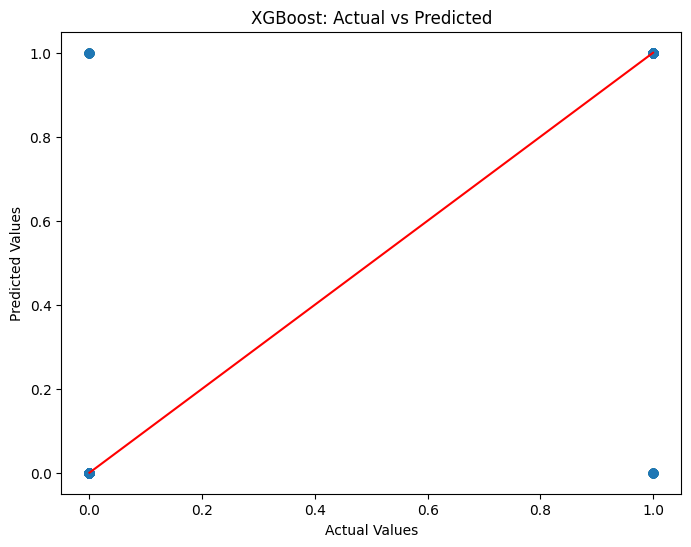

<Figure size 1000x600 with 0 Axes>

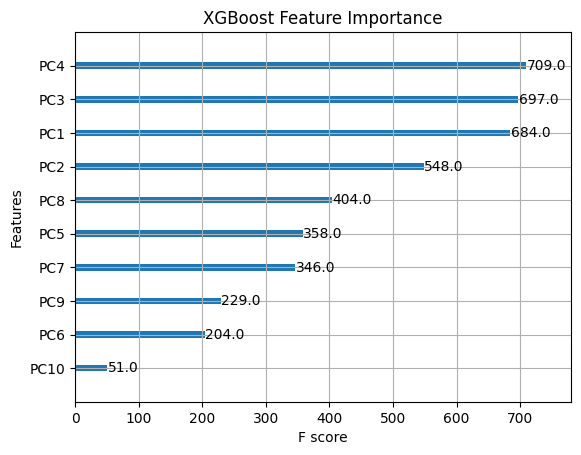

In [111]:
# Cell 3: XGBoost Classifier Model and Evaluation
# Train XGBoost Model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_pca, y_train)
y_pred_xgb = xgb_model.predict(X_test_pca)

# Evaluate XGBoost Model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"XGBoost Test Accuracy: {accuracy_xgb:.2f}")
print(f"XGBoost Test Precision: {precision_xgb:.2f}")
print(f"XGBoost Test Recall: {recall_xgb:.2f}")

# Plot Confusion Matrix for XGBoost
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

# XGBoost Scatter Plot (Actual vs. Predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost: Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Ideal line
plt.show()

# Plot Feature Importance
from xgboost import plot_importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10) # Adjust max_num_features as needed
plt.title('XGBoost Feature Importance')
plt.show()

Optimized Gradient Boosting Classifier Model Results (Simplified):
Accuracy: 0.9665
Precision: 0.9641137855579869
Recall: 0.9626392833733887
Confusion Matrix:
 [[5259  164]
 [ 171 4406]]


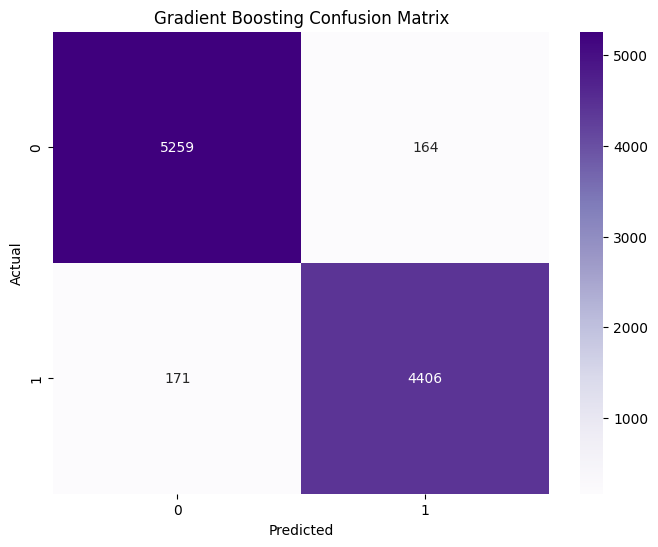

Optimized Gradient Boosting Cross-Validation Scores: [0.95179806 0.94771784 0.9626556 ]
Optimized Gradient Boosting Mean Cross-Validation Score: 0.9540571692023975


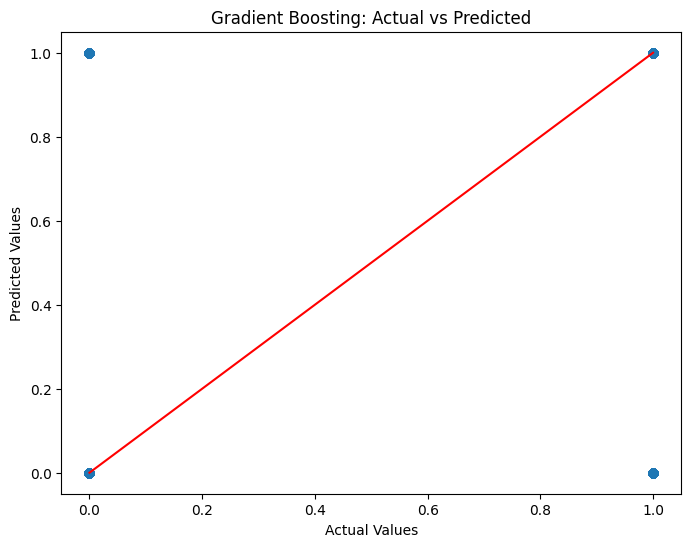

In [110]:
# Cell 4: Optimized Gradient Boosting Classifier Model and Evaluation (Simplified)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Train Gradient Boosting Classifier Model (Simplified Parameters)
model_gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42, subsample=0.8)

model_gb.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_gb = model_gb.predict(X_test)

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

print("Optimized Gradient Boosting Classifier Model Results (Simplified):")
print(f"Accuracy: {accuracy_gb}")
print(f"Precision: {precision_gb}")
print(f"Recall: {recall_gb}")
print("Confusion Matrix:\n", conf_matrix_gb)

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boosting Confusion Matrix')
plt.show()

# Cross-Validation
cross_val_scores_gb = cross_val_score(model_gb, X_train_resampled, y_train_resampled, cv=3) #reduce cv folds
print(f"Optimized Gradient Boosting Cross-Validation Scores: {cross_val_scores_gb}")
print(f"Optimized Gradient Boosting Mean Cross-Validation Score: {cross_val_scores_gb.mean()}")

# Gradient Boosting Graph Visualization (Scatter plot of actual vs predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Gradient Boosting: Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()